# Minimal Sample
In this notebook, we will explore how to use a model to make different predictions, decompose the contributions from longwave and shortwave, and find the extracted mean structure.

In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import glob
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED/')
from util import read_and_proc,ts_models,benchmark
from copy import deepcopy
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})
import random

# Basic Settings

In [5]:
# Read in processed data
storedata,store_notensor,store_axisym,store_minus,store_addasym,store_minusasym,store_axisym_preserve = {},{},{},{},{},{},{}
for i in tqdm(range(40)):
    storedata[i] = benchmark.prepare_tensors('./processed/haiyan_store',i,23,'No')
    store_notensor[i] = benchmark.prepare_tensors('./processed/haiyan_store',i,23,'Yes')

  0%|          | 0/40 [00:00<?, ?it/s]

# Read the best model

In [7]:
bestmodel = read_and_proc.depickle('./processed/minimum/bestmodel.obj')

# Make some predictions

## (1) Use the best model to predict the intensification rates of the training dataset twice

In [66]:
bestsplit=26

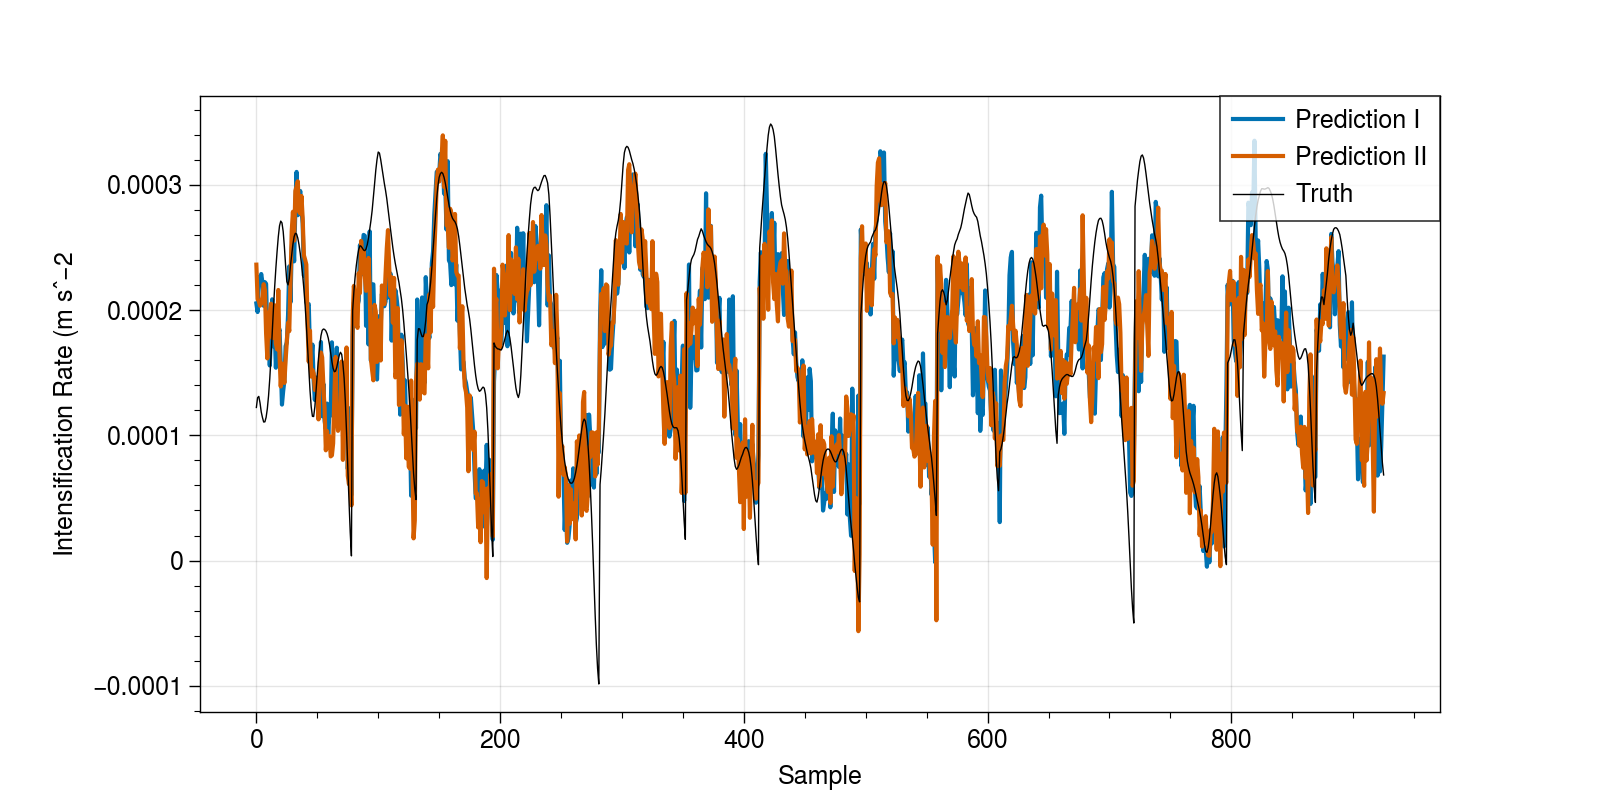

In [90]:
fig,ax1 = plt.subplots(1,figsize=(8,4))
ax1.plot(np.squeeze(bestmodel(storedata[bestsplit]['train'][0])[0].detach().numpy().transpose()),label='Prediction I')
ax1.plot(np.squeeze(bestmodel(storedata[bestsplit]['train'][0])[0].detach().numpy().transpose()),label='Prediction II')
ax1.plot(store_notensor[bestsplit]['train'][1],lw=0.5,c='k',label='Truth')
plt.legend(loc=1)
plt.xlabel('Sample')
plt.ylabel('Intensification Rate (m s$ˆ{-2}$')
plt.show()

Observe that the model prediction is different every time we run it on the same dataset. This variability is attributed to the random sampling of the normal distributions in the middle part of the model. The variability alows us to quantify the spread of the model predictions. In the mean time, it is not reasonable to report the skills of the model with only one set of predictions. In our study, the deterministic skill scores are calculated by comparing the truth and the mean of 30 different model predictions.

In [68]:
pred = [np.squeeze(bestmodel(storedata[bestsplit]['train'][0])[0].detach().numpy().transpose()) for _ in range(30)]

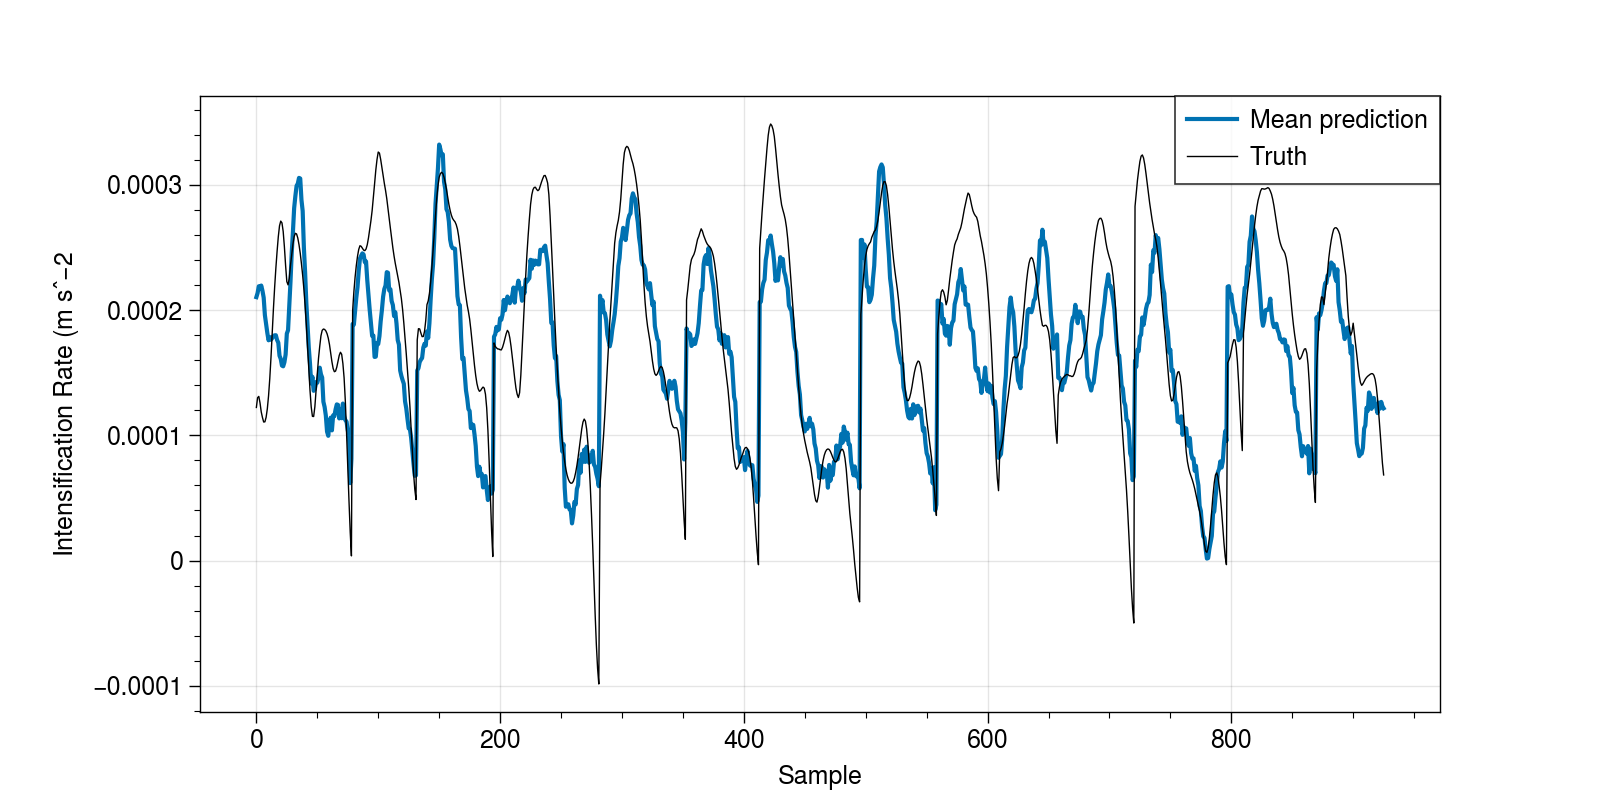

In [91]:
fig,ax1 = plt.subplots(1,figsize=(8,4))
ax1.plot(np.mean(np.asarray(pred),axis=0),label='Mean prediction')
ax1.plot(store_notensor[bestsplit]['train'][1],lw=0.5,c='k',label='Truth')
plt.legend(loc=1)
plt.xlabel('Sample')
plt.ylabel('Intensification Rate (m s$ˆ{-2}$')
plt.show()

## (2) Decompose the longwave and shortwave contributions with Equations in the SI

The SI has a detailed description on how to calculate the longwave and shortwave radiation contribution to intensification from the bias and weights terms in the ML model. In the benchmark.py script we have a function to calculate the two contribution terms and the persistence term (overall model bias).

In [70]:
# Calculate the effective weights (see SI for details); -40 and -20 are the indices of the longwave PCs in the input data
ALW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[bestsplit]['train'][0],bestmodel,'LW',[-40,-20])
ASW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[bestsplit]['train'][0],bestmodel,'SW',[-40,-20])

# Calculate the overall bias (see SI for details)
B = benchmark.analysis_patterns(None,None).new_b_vae(store_notensor[bestsplit]['train'][0],bestmodel,[-40,-20])

# Weights to get the $\Pi_{\mu, LW}$, $\Pi_{\mu, SW}$ structures from the SI equations
fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[bestsplit]['train'][0],bestmodel,'LW')
flsw = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[bestsplit]['train'][0],bestmodel,'SW')

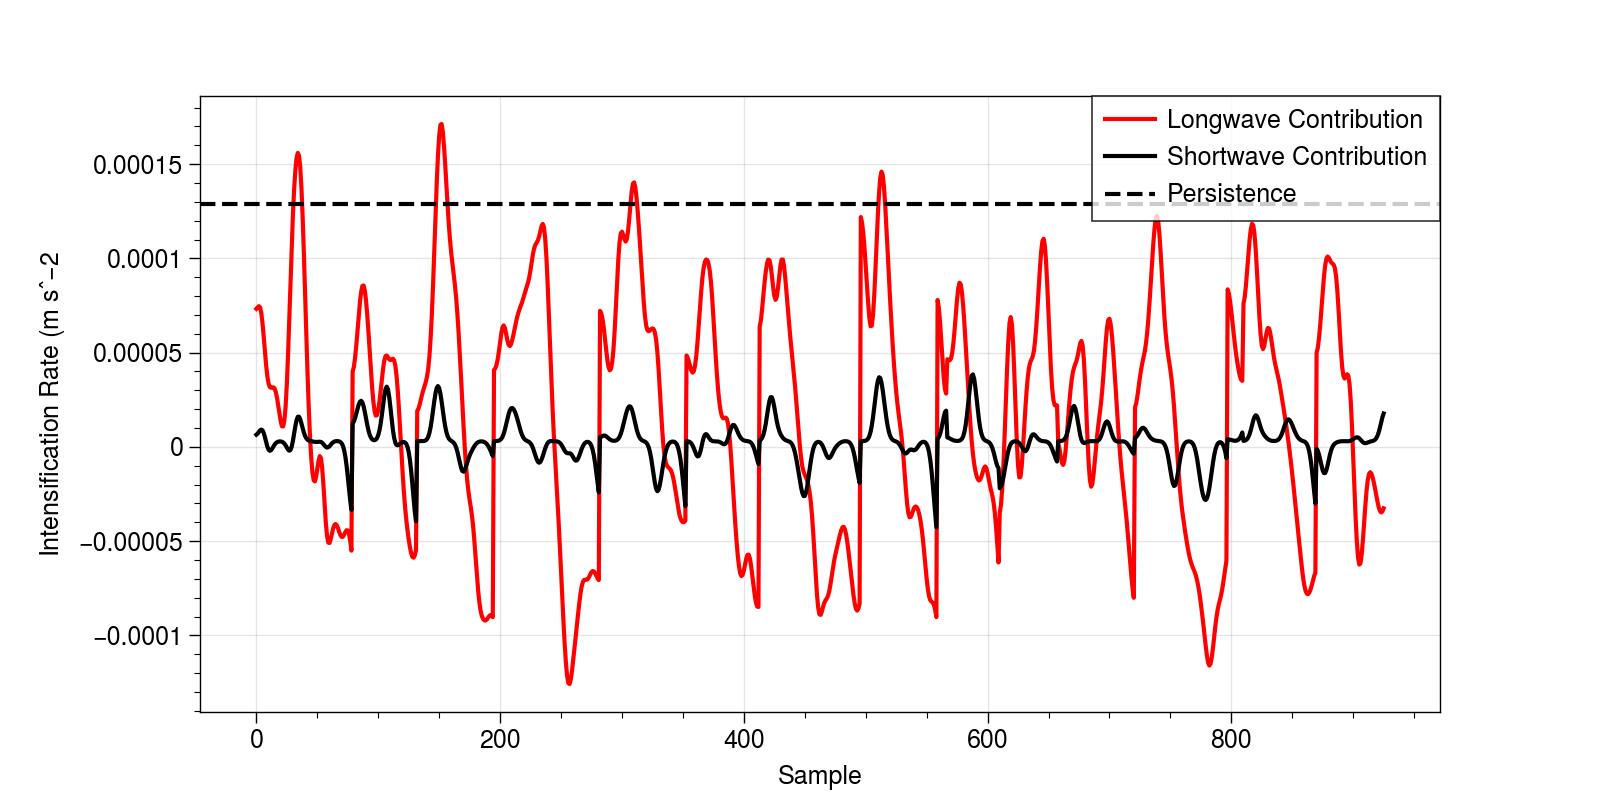

In [92]:
fig,ax1 = plt.subplots(1,figsize=(8,4))
ax1.plot(ALW*np.dot(np.asarray(store_notensor[bestsplit]['train'][0])[:,-40:-20],fl),c='r',lw=1.5,label='Longwave Contribution')#79:132])
ax1.plot(ASW*np.dot(np.asarray(store_notensor[bestsplit]['train'][0])[:,-20:],flsw),c='k',lw=1.5,label='Shortwave Contribution')
ax1.axhline(y=B,label='Persistence',c='k',lw=1.5,ls='--')
plt.legend(loc=1)
plt.xlabel('Sample')
plt.ylabel('Intensification Rate (m s$ˆ{-2}$')
plt.show()

Observe from the time series of the three terms that longwave contribution is almost always larger than the shortwave term, a positive longwave contribution results in an intensification rates beyond the persistence baseline.

# Look at the structures

Now we do further analysis with the SI equations. Specifically, we would like to obtain the extracted mean longwave structure from the eigenvectors stored in the PCA object. \

The procedure is simple: we first get the right weight for each PC using the equation provided in the SI, then we will use a dot product operation to combine different PCs into one coherent structure.

In [81]:
# PCA objects produced by the scikit-learn library
pcalw = read_and_proc.depickle('./processed/haiyan_store/pca/lw/'+str(bestsplit)+'/PCA3D.pkg')

In [83]:
# Weights to get the $\Pi_{\mu, LW}$, $\Pi_{\mu, SW}$ structures from the SI equations
fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[bestsplit]['train'][0],bestmodel,'LW')
# getting the 3D mean and log(sigma^2) structures with the weights
flas = np.squeeze(np.dot(fl,pcalw['lw'].components_[:20,:])).reshape(10,360,208)

Let us visualize "flas" first, we will plot a cross section of "flas" (mean LW structure) at 100 hPa

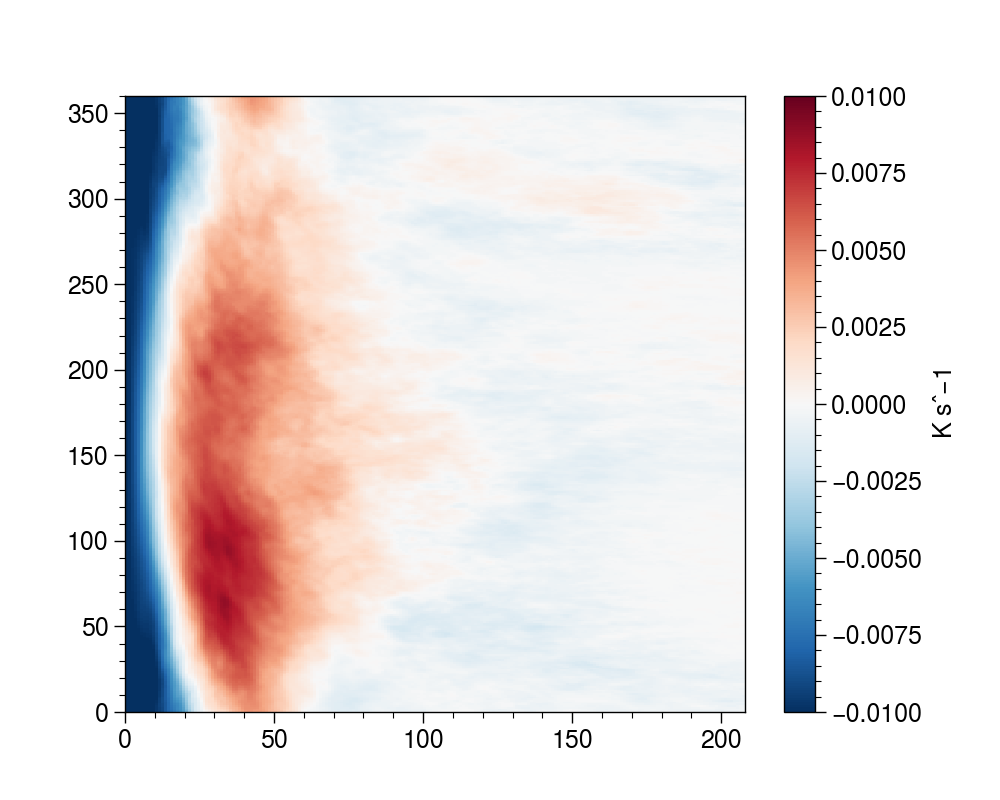

In [100]:
fig,ax1 = plt.subplots(1,figsize=(5,4))
plt.pcolormesh(np.asarray(flas)[-1],cmap='RdBu_r',vmin=-0.01,vmax=0.01)
plt.colorbar(label='K s$ˆ{-1}$')
plt.show()

This figure is not very intuitive if we want to look at the spatial distribution of the LW anomaly, primarily because it's in polar coordinate. In the *read_and_proc.py* helper script, we provide a useful function *proc_tocart()* to convert the above 2D figure into Cartesian coordinates.

In [98]:
# For radial coordinates -> cartesian conversion
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))

cart_map = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(flas)[-1,...],ANGLE,True,False))))

Let's plot the converted map

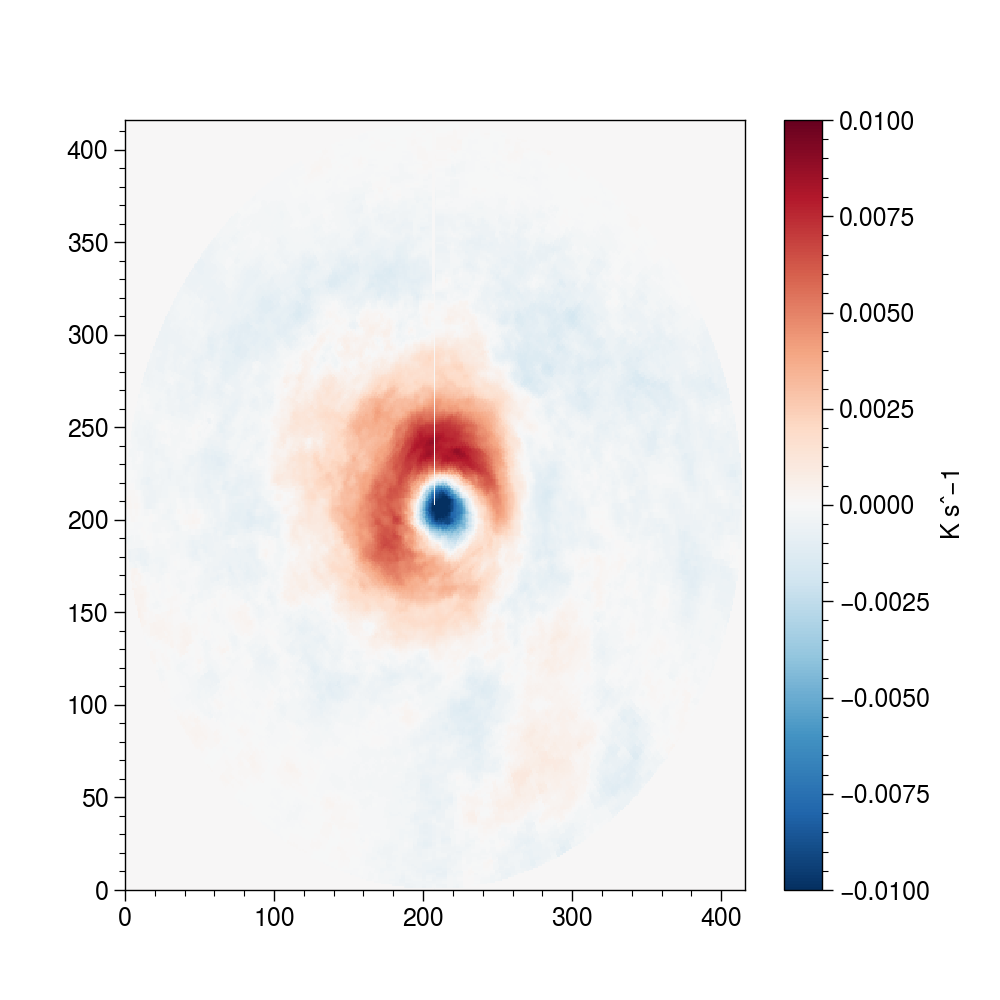

In [101]:
fig,ax1 = plt.subplots(1,figsize=(5,5))
plt.pcolormesh(cart_map,cmap='RdBu_r',vmin=-0.01,vmax=0.01)
plt.colorbar(label='K s$ˆ{-1}$')
plt.show()

Now you can clearly see how the LW anomaly at 100 hPa is distributed in the mean LW structure. Plotting this in cartesian coordinate is preferable because we can easily conclude that the mean structure has more upper level longwave heating anomaly in the northern half of the TC than the southern half of the TC.